In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import find_contours
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
import os
import random

### ABCF 이미지 로드

In [2]:
def show_image(image, title='Image'):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

In [3]:
def show_image_new(image, title='Image'):
    # 이미지를 uint8 형식으로 변환
    image_uint8 = (image * 255).astype(np.uint8)
    
    # 이미지 출력
    if image_uint8 is not None:
        plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("이미지를 불러올 수 없습니다.")

In [4]:
def load_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    selected_image = random.choice(image_files)
    image_path = os.path.join(folder_path, selected_image)
    return image_path

In [5]:
folder_A = "A"
folder_B = "B"
folder_C = "C"
folder_F = "F"
A = load_random_image(folder_A)
B = load_random_image(folder_B)
C = load_random_image(folder_C)
F = load_random_image(folder_F)

In [138]:
lists = [A, B, C, F]
values = ["A", "B", "C", "F"]
title_dict = {value: list for list, value in zip(lists, values)}
title_dict

{'A': 'A/setimg4_labelimg_22_Liniya 1id281_5448.png',
 'B': 'B/setimg4_labelimg_86_Liniya 1id296_5789.png',
 'C': 'C/setimg6_sb_549_Liniya 1id106_3804.png',
 'F': 'F/Liniya 1id62_1287.png'}

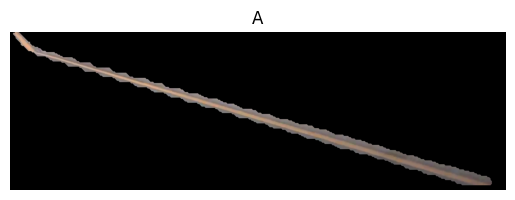

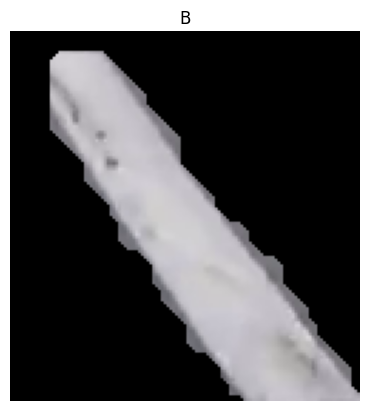

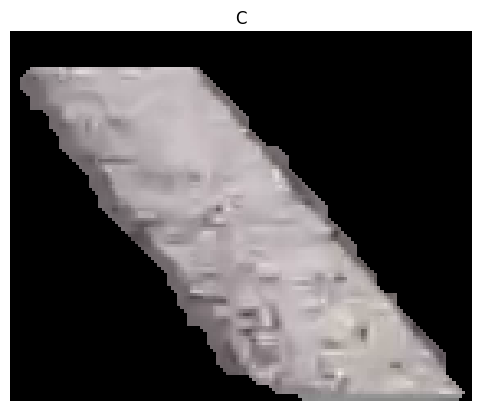

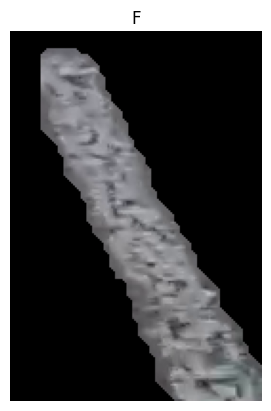

In [139]:
for var, value in zip(lists, values):
    image = cv2.imread(var)
    show_image(image, title=value)

In [140]:
# ### 예시

# import numpy as np
# from skimage.measure import find_contours

# # 예제 이미지: 2D 배열
# image = np.array([
#     [0, 0, 0, 0, 0],
#     [0, 1, 1, 1, 0],
#     [0, 1, 0, 1, 0],
#     [0, 1, 1, 1, 0],
#     [0, 0, 0, 0, 0]
# ])

# # 경계선을 찾음
# contours = find_contours(image, level=0.9)

# # 결과 출력
# for contour in contours:
#     print(contour)
    

In [141]:
# import matplotlib.pyplot as plt

# # 이미지 시각화
# fig, ax = plt.subplots()
# ax.imshow(image, cmap=plt.cm.gray)

# # 경계선을 이미지 위에 플로팅
# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

# 경계선 좌표
# - [[1. , 1.5], [1.5, 1. ], [2. , 1.5], [1.5, 2. ], [1. , 1.5]]
# - [1. , 1.5]: (1, 1.5) 좌표, 즉 (1행, 1.5열) 위치
# - [1.5, 1. ]: (1.5, 1) 좌표, 즉 (1.5행, 1열) 위치
# - [2. , 1.5]: (2, 1.5) 좌표, 즉 (2행, 1.5열) 위치
# - [1.5, 2. ]: (1.5, 2) 좌표, 즉 (1.5행, 2열) 위치
# - [1. , 1.5]: (1, 1.5) 좌표, 즉 (1행, 1.5열) 위치 (폐곡선 형태로 마지막 점이 첫 번째 점과 같음)

### find_contours
### 능동 윤곽선 모델 (Active Contour Model)

- 특정 레벨(임계값)을 기준으로 등고선을 찾는 방식
- 이 함수는 2차원 배열에서 연속적인 등고선의 좌표를 반환
- 각 좌표는 이미지의 경계를 나타내는 점

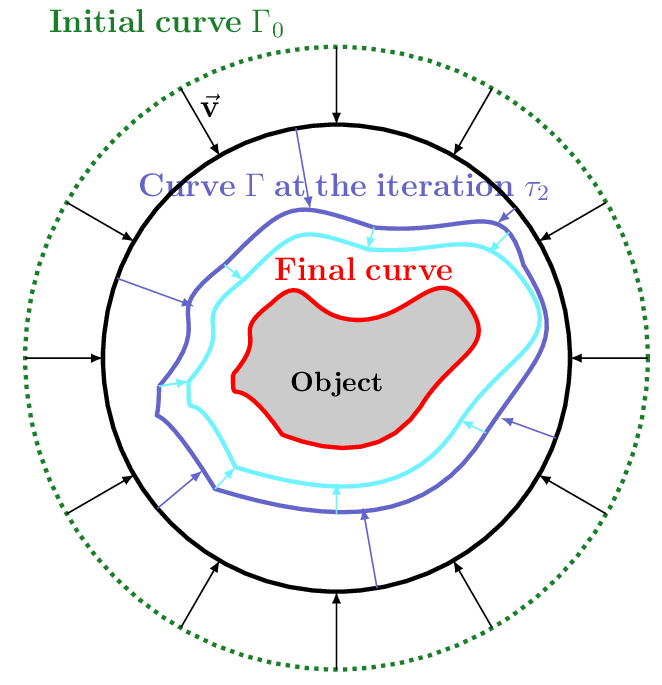
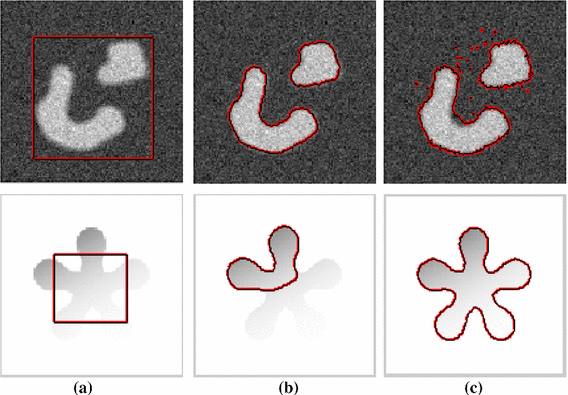

### 워터셰드(Watershed)

이미지의 픽셀 값(밝기 값)을 높이 값으로 간주하여, 이미지를 산과 계곡으로 해석합니다. 밝은 영역은 산봉우리, 어두운 영역은 계곡에 해당

1. 지형학적 해석:

- 이미지의 픽셀 값(밝기 값)을 높이 값으로 간주하여, 이미지를 산과 계곡으로 해석합니다. 밝은 영역은 산봉우리, 어두운 영역은 계곡에 해당합니  다.

2. 침수 과정:
- 물이 낮은 곳(계곡)부터 채워지기 시작합니다. 물이 채워지는 과정에서 계곡의 경계가 만나기 전까지 물이 채워집니다.

3. 마커 설정:
- 특정 지점들을 마커로 설정하여, 각 마커에서 시작하는 물이 차오르는 과정을 시뮬레이션합니다. 마커는 객체의 중심부나 분할하려는 영역에 수동 또는 자동으로 설정됩니다.

4. 경계 설정:
- 서로 다른 마커에서 시작한 물이 만나는 지점을 경계로 설정하여, 서로 다른 객체를 분리합니다. 경계선을 따라 새로운 객체를 정의하게 됩니다.

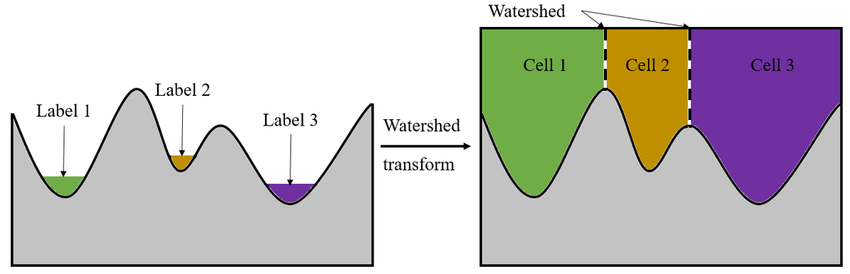
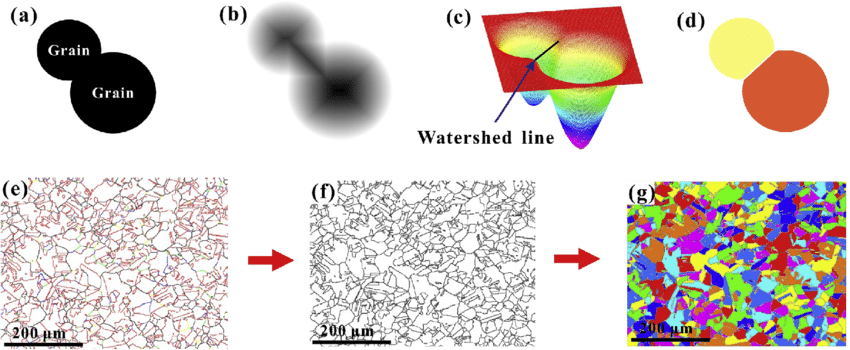

In [142]:
# Step 2: Preprocess the image
processed_images = {}

for var, value in zip(lists, values):
    image = cv2.imread(var)
    
    if image is not None:
        # 이미지를 그레이스케일로 변환
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 이미지를 float 타입으로 변환
        image_gray = img_as_float(image_gray)

        # 강조와 약화를 위한 마스크 생성
        mask_strong = image_gray >= 0.7
        mask_weak = (image_gray < 0.4) & (image_gray >= 0)
        
        # 마스크를 사용하여 강조 및 약화 적용
        image_strong = image_gray.copy()
        image_weak = image_gray.copy()
        
        image_strong[mask_strong] = image_strong[mask_strong] * 1.2  # 강조
        image_weak[mask_weak] = image_weak[mask_weak] * 0.7  # 약화
        
        # 두 이미지 합치기
        image_combined = np.maximum(image_strong, image_weak)
        
        # Otsu 이진화 적용
        thresh = threshold_otsu(image_gray)
        image_binary = image_gray > thresh
        
        processed_images[value] = {
            'gray': image_gray,
            'combined': image_combined,
            'binary': image_binary
        }

In [143]:
processed_images

{'A': {'gray': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'combined': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'binary': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 'B': {'gray': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,


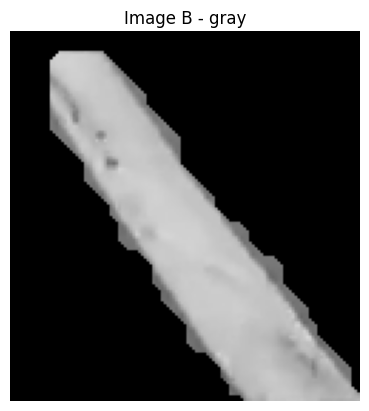

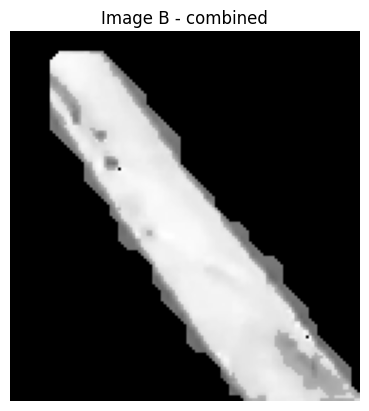

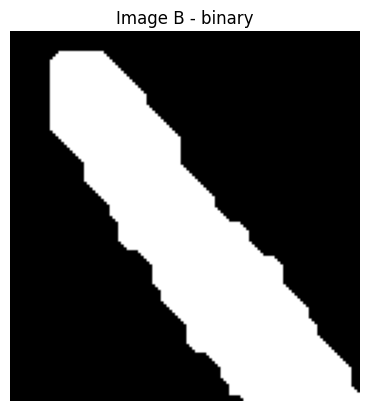

In [144]:
image_F_gray = processed_images['B']['gray']
image_F_combined = processed_images['B']['combined']
image_F_binary = processed_images['B']['binary']
show_image_new(image_F_gray, title='Image B - gray')
show_image_new(image_F_combined, title='Image B - combined')
show_image_new(image_F_binary, title='Image B - binary')

In [145]:
# Step 3: 컨투어 찾기
contours_dict = {}

for value, processed_image in processed_images.items():
    image_smooth = processed_image['gray']
    contours = find_contours(image_smooth, level=0.6)
    contours_dict[value] = contours

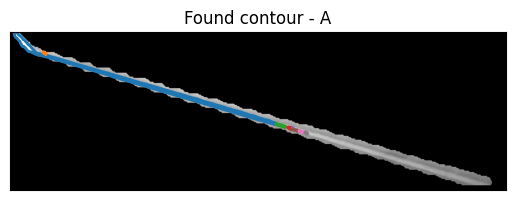

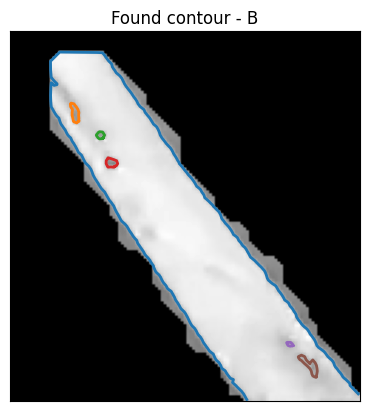

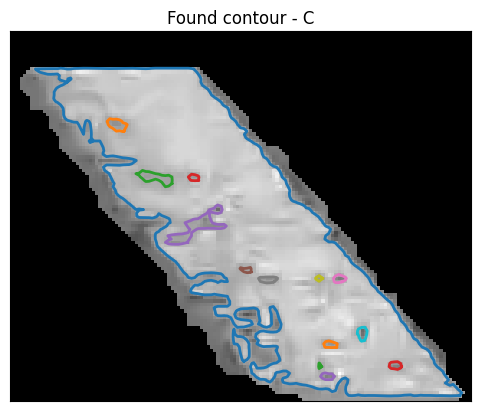

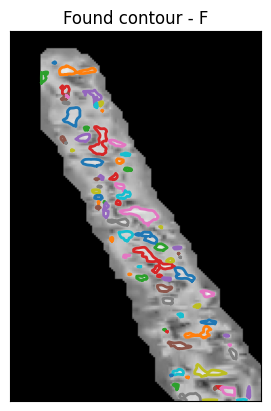

In [146]:
# 컨투어 시각화
for value, processed_image in processed_images.items():
    image_gray = processed_image['gray']
    contours = contours_dict[value]
    
    fig, ax = plt.subplots()
    ax.imshow(image_gray, cmap=plt.cm.gray)

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f'Found contour - {value}')
    plt.show()

In [147]:
def watershed_segmentation(binary_image):
    # 워터셰드 세그멘테이션을 위한 거리 변환
    dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
    ret, markers = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    markers = cv2.connectedComponents(markers.astype(np.uint8))[1]
    segmented = watershed(-dist_transform, markers, mask=binary_image)
    return segmented

In [148]:
def find_contours_in_segmented_image(segmented_image):
    contours, _ = cv2.findContours(segmented_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

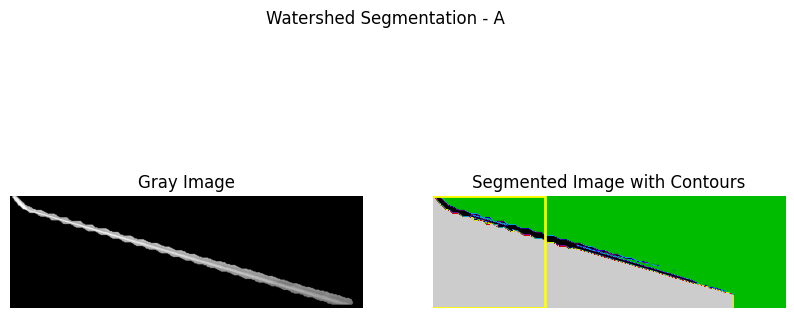

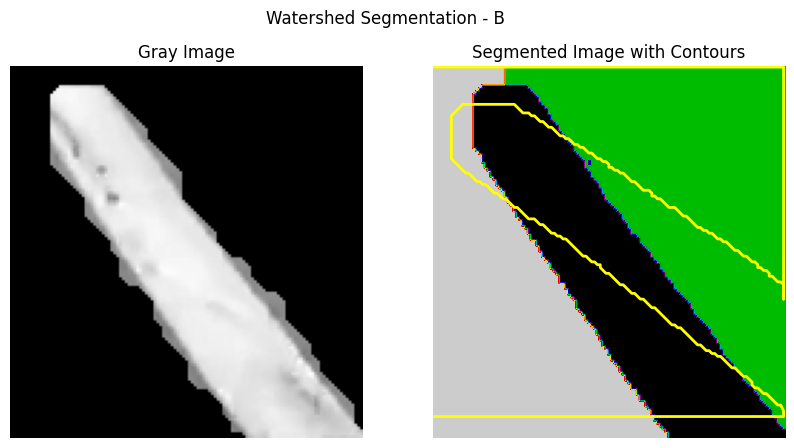

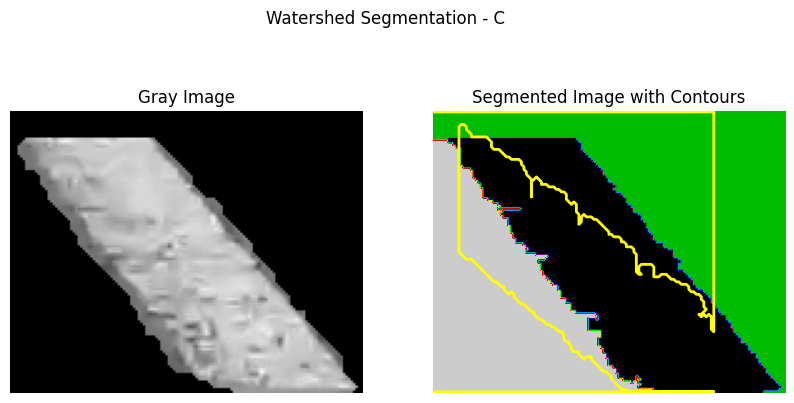

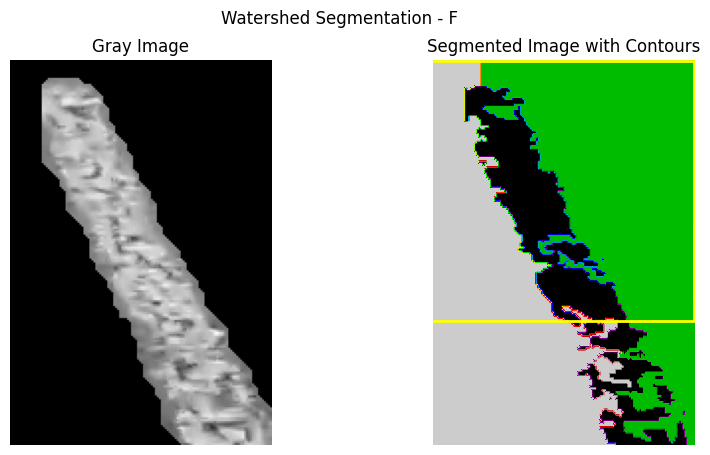

In [158]:
# 워터셰드 세그멘테이션 및 시각화 수행
for value, processed_image in processed_images.items():
    gray_image = processed_image['gray']
    
    # 그레이스케일 이미지를 CV_8UC1 형식으로 변환
    gray_image_uint8 = cv2.convertScaleAbs(gray_image)

    # 그레이스케일 이미지를 이진화하여 워터셰드 세그멘테이션을 수행
    ret, binary_image = cv2.threshold(gray_image_uint8, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    segmented_image = watershed_segmentation(binary_image)
    contours = find_contours_in_segmented_image(segmented_image)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # 원본 그레이스케일 이미지
    axes[0].imshow(gray_image, cmap='gray')
    axes[0].set_title('Gray Image')
    axes[0].axis('off')
    
    # 워터셰드 세그멘테이션 결과에 컨투어 시각화
    axes[1].imshow(segmented_image, cmap='nipy_spectral')
    axes[1].set_title('Segmented Image with Contours')
    axes[1].axis('off')
    
    # 이미지 경계 내에 있는 점들로 컨투어를 그립니다.
    for contour in contours:
        valid_contour = contour.squeeze()
        valid_contour[:, 0] = np.clip(valid_contour[:, 0], 0, gray_image.shape[0]-1)
        valid_contour[:, 1] = np.clip(valid_contour[:, 1], 0, gray_image.shape[1]-1)
        axes[1].plot(valid_contour[:, 1], valid_contour[:, 0], linewidth=2, color='yellow')  # x와 y 좌표 순서에 유의
    
    plt.suptitle(f'Watershed Segmentation - {value}')
    plt.show()


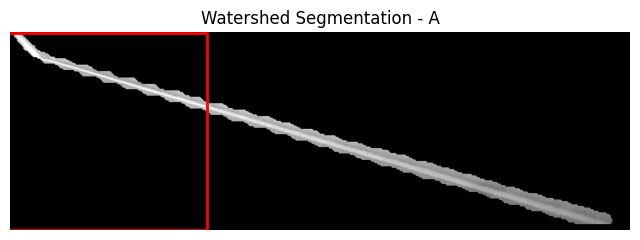

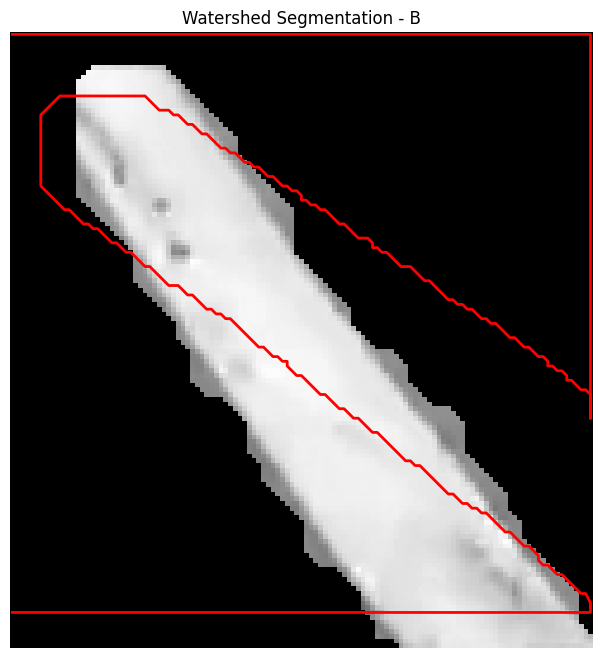

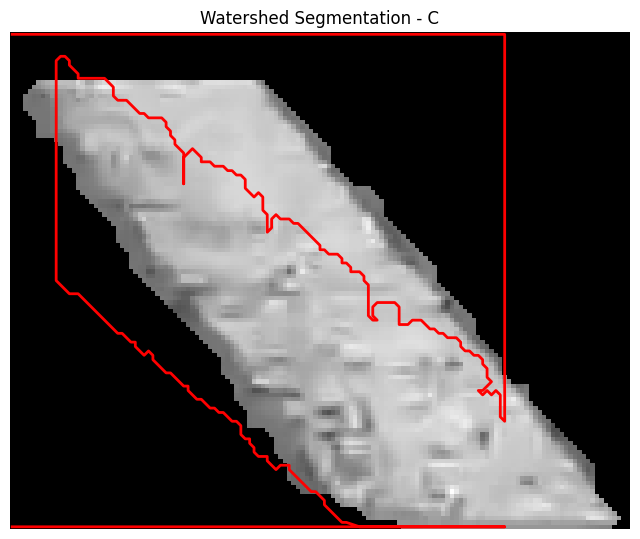

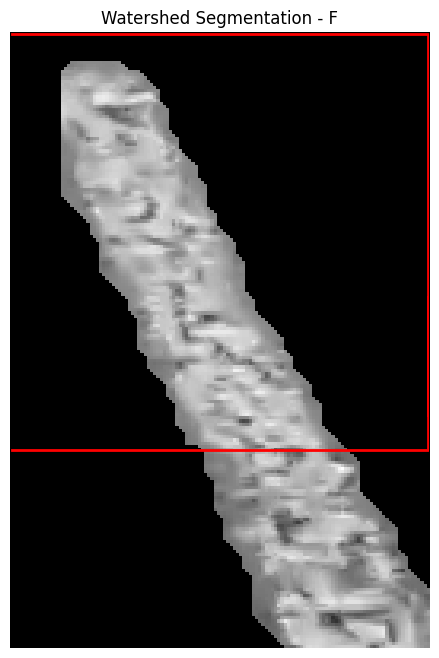

In [160]:
# 워터셰드 세그멘테이션 및 시각화 수행
for value, processed_image in processed_images.items():
    gray_image = processed_image['gray']
    
    # 그레이스케일 이미지를 CV_8UC1 형식으로 변환
    gray_image_uint8 = cv2.convertScaleAbs(gray_image)

    # 그레이스케일 이미지를 이진화하여 워터셰드 세그멘테이션을 수행
    ret, binary_image = cv2.threshold(gray_image_uint8, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    segmented_image = watershed_segmentation(binary_image)
    contours = find_contours_in_segmented_image(segmented_image)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(8, 8))

    # 원본 그레이스케일 이미지
    ax.imshow(gray_image, cmap='gray')
    ax.set_title('Gray Image')

    # 이미지 경계 내에 있는 점들로 컨투어를 그립니다.
    for contour in contours:
        valid_contour = contour.squeeze()
        valid_contour[:, 0] = np.clip(valid_contour[:, 0], 0, gray_image.shape[0]-1)
        valid_contour[:, 1] = np.clip(valid_contour[:, 1], 0, gray_image.shape[1]-1)
        ax.plot(valid_contour[:, 1], valid_contour[:, 0], linewidth=2, color='red')  # x와 y 좌표 순서에 유의

    ax.axis('off')
    plt.title(f'Watershed Segmentation - {value}')
    plt.show()


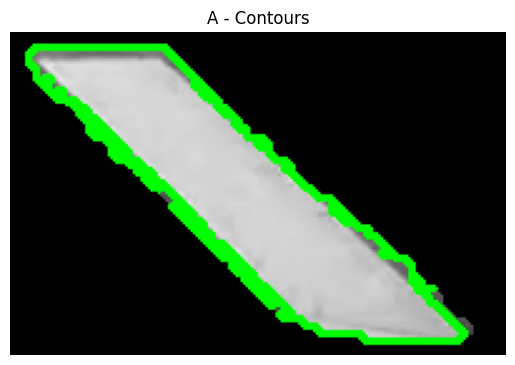

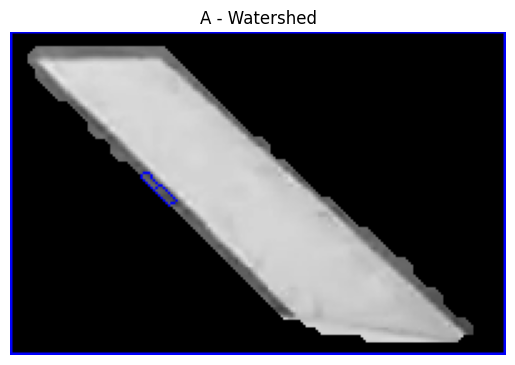

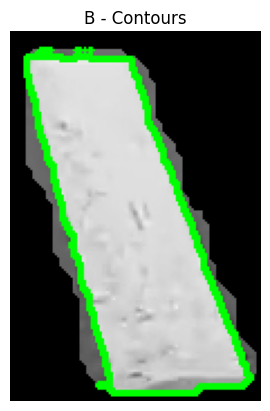

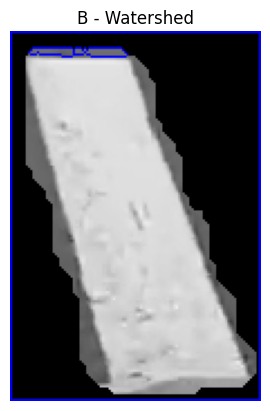

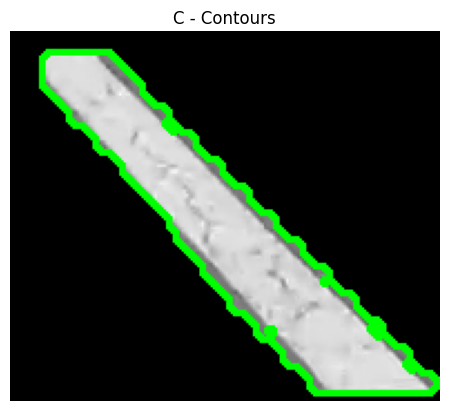

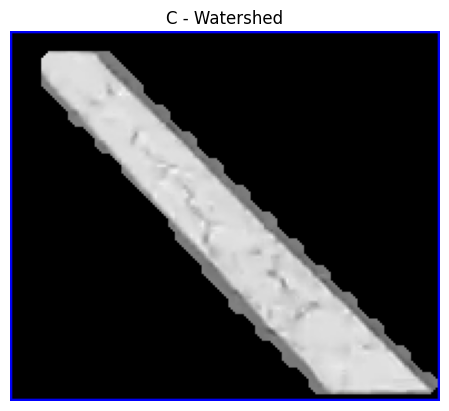

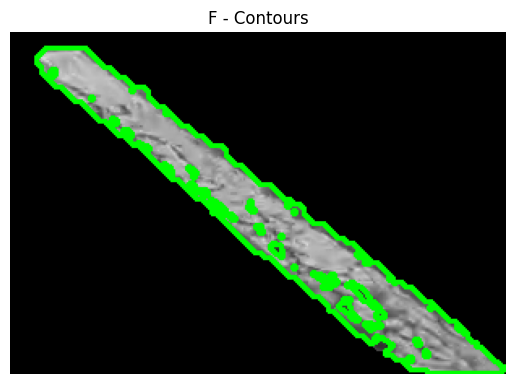

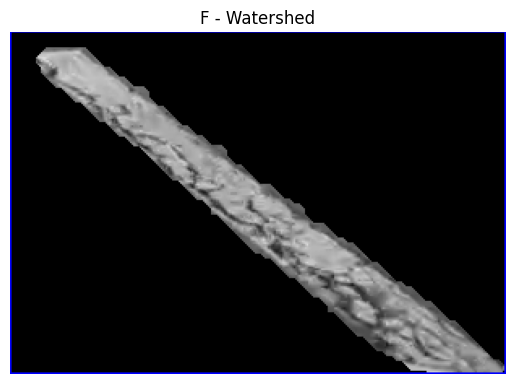

In [91]:
# Step 3: Contour Extraction and Watershed Segmentation
for key in processed_images.keys():
    image_gray = processed_images[key]['gray']
    image_combined = processed_images[key]['combined']
    image_binary = processed_images[key]['binary']

    # Find contours
    contours, hierarchy = cv2.findContours(image_binary.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the original image
    image_contours = cv2.cvtColor((image_gray * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)
    show_image(image_contours, title=f"{key} - Contours")

    # Apply Watershed algorithm
    image_gray_8bit = (image_gray * 255).astype(np.uint8)
    ret, markers = cv2.connectedComponents(image_binary.astype(np.uint8))
    
    # Marker labelling
    markers = markers + 1
    markers[image_binary == 0] = 0
    
    # Apply the Watershed algorithm
    image_watershed = cv2.cvtColor(image_gray_8bit, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_watershed, markers)
    image_watershed[markers == -1] = [255, 0, 0]
    
    show_image(image_watershed, title=f"{key} - Watershed")

    # Saving the processed images
    output_folder = 'processed_images'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cv2.imwrite(os.path.join(output_folder, f"{key}_contours.png"), image_contours)
    cv2.imwrite(os.path.join(output_folder, f"{key}_watershed.png"), image_watershed)

In [352]:
contours_dict = {}

# Step 3: Find the initial contour from the mask
for value, processed_image in processed_images.items():
    image_smooth = processed_image['combined']
    contours = find_contours(image_smooth, level=0.6)
    contours_dict[value] = contours

In [353]:
contours_dict # 특정 임계값을 기준으로 추출한 경계선의 좌표

#이미지에서 연속적인 등고선을 찾아 그 좌표를 반환합니다. 이 좌표들은 이미지의 경계를 나타내는 점들의 집합입니다.

{'A': [array([[205.16      , 420.        ],
         [205.        , 419.63636364],
         [204.46153846, 419.        ],
         [204.        , 418.45454545],
         [203.44444444, 418.        ],
         [203.125     , 417.        ],
         [203.        , 416.        ],
         [202.4       , 415.        ],
         [202.4       , 414.        ],
         [202.07692308, 413.        ],
         [202.        , 412.86666667],
         [201.38095238, 412.        ],
         [201.        , 411.2       ],
         [200.81818182, 411.        ],
         [200.22222222, 410.        ],
         [200.        , 409.2       ],
         [199.75      , 409.        ],
         [199.        , 408.        ],
         [198.375     , 407.        ],
         [198.1       , 406.        ],
         [198.        , 405.75      ],
         [197.57142857, 405.        ],
         [197.        , 404.        ],
         [196.625     , 403.        ],
         [196.5       , 402.        ],
         [196.      

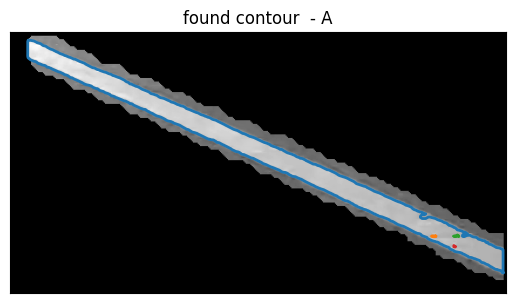

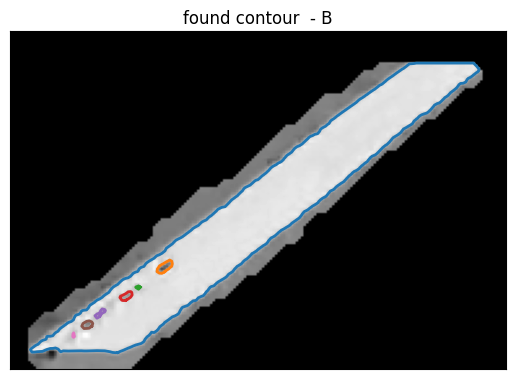

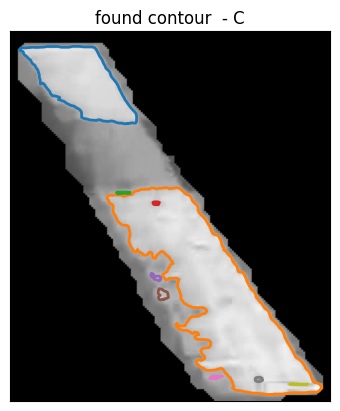

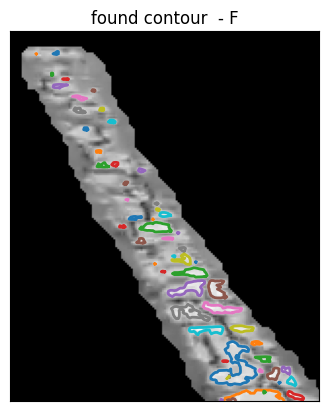

In [354]:
for value, processed_image in processed_images.items():
    image_gray = processed_image['gray']
    contours = contours_dict[value]
    
    fig, ax = plt.subplots()
    ax.imshow(image_gray, cmap=plt.cm.gray)

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f'found contour  - {value}')
    plt.show()

In [355]:
# 가장 긴 윤곽선을 선택 (가장 큰 객체를 초기화하기 위해)
longest_contour = max(contours, key=len)

In [356]:
longest_contour

array([[181.15789474, 113.        ],
       [181.11764706, 112.        ],
       [181.        , 111.71428571],
       [180.        , 111.        ],
       [180.28571429, 110.        ],
       [180.42857143, 109.        ],
       [180.39285714, 108.        ],
       [180.40540541, 107.        ],
       [180.21875   , 106.        ],
       [180.        , 105.46153846],
       [179.        , 105.6       ],
       [178.60869565, 105.        ],
       [178.5862069 , 104.        ],
       [178.26666667, 103.        ],
       [178.        , 102.69230769],
       [177.        , 102.73076923],
       [176.5       , 103.        ],
       [176.        , 103.5       ],
       [175.53333333, 104.        ],
       [175.        , 104.72727273],
       [174.84210526, 105.        ],
       [174.72727273, 106.        ],
       [174.        , 106.66666667],
       [173.85185185, 107.        ],
       [173.82142857, 108.        ],
       [173.76923077, 109.        ],
       [173.73684211, 110.        ],
 

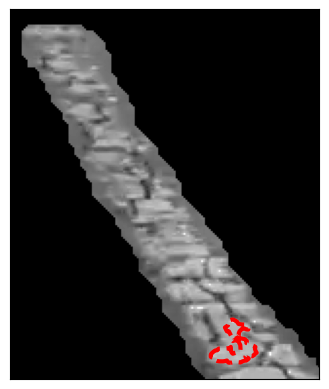

In [357]:
# 이미지와 경계선 시각화
fig, ax = plt.subplots()
ax.imshow(image_smooth, cmap=plt.cm.gray)

# 경계선을 이미지 위에 플로팅
ax.plot(longest_contour[:, 1], longest_contour[:, 0], '--r', lw=3)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### 능동 윤곽선 모델 (Active Contour Model)

- 스네이크 모델은 세 가지 주요 에너지 성분을 최소화하여 윤곽선을 진화시킵니다:

1. 내부 에너지 (Internal Energy):

- Elasticity (alpha): 윤곽선의 길이를 줄이려는 성분입니다. 값이 높을수록 윤곽선이 더 직선 형태로 유지됩니다.
- Bending (beta): 윤곽선의 굴곡을 줄이려는 성분입니다. 값이 높을수록 윤곽선이 덜 구부러지게 됩니다.

2. 외부 에너지 (External Energy):

이미지의 경계 정보와 같은 외부 요소에서 기인하는 에너지입니다. 윤곽선을 이미지 경계로 끌어당기는 역할을 합니다. 이 값은 이미지의 그래디언 트에 의해 결정됩니다.

바람직한 에너지 (Balloon Energy):

- Gamma: 윤곽선의 움직임을 제어하는 파라미터로, 외부 에너지가 없더라도 윤곽선을 확장 또는 수축시키는 힘을 제공합니다.
- 전체 과정 요약:
- 초기화: 초기 윤곽선을 설정합니다. 이 윤곽선은 관심 영역 주위에 배치됩니다.
- 진화: 윤곽선이 에너지를 최소화하도록 조정됩니다. 내부 에너지와 외부 에너지의 균형을 맞추면서 이미지의 경계를 따라 윤곽선이 움직입니다.
- 결과: 최종 윤곽선은 이미지의 객체 경계를 따라 배치됩니다.

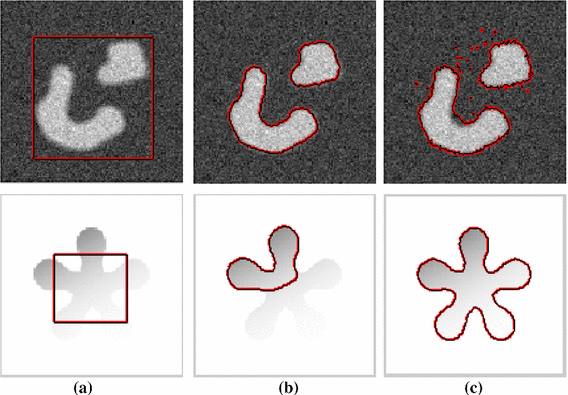
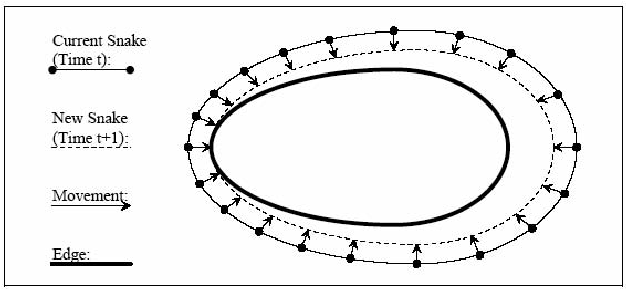

In [358]:
# Step 4: Evolve the snake
snake = active_contour(image_smooth, longest_contour, alpha=0.1, beta=1, gamma=0.001)

In [359]:
snake

array([[182.15789474, 118.01880077],
       [182.11764706, 116.74858639],
       [182.        , 115.95208938],
       [181.        , 114.2950338 ],
       [181.28571429, 112.67985187],
       [181.42857143, 110.77519904],
       [181.39285714, 109.13782679],
       [181.40540541, 107.83158355],
       [181.21875   , 106.6488325 ],
       [181.        , 105.59636842],
       [180.        , 104.83512945],
       [179.60869571, 104.15241317],
       [179.58620748, 103.27794099],
       [179.26668   , 102.61035404],
       [179.00017289, 102.26483125],
       [178.00877664, 102.11726381],
       [176.86126692, 102.21474352],
       [176.17413263, 102.59873866],
       [174.23090287, 103.05880885],
       [173.95867163, 103.75600384],
       [173.80346371, 104.04237252],
       [173.72289625, 105.0179568 ],
       [172.99983819, 105.68406975],
       [172.85182581, 106.03788699],
       [172.82142045, 107.02378084],
       [172.76922661, 107.95549303],
       [172.73683801, 108.05619676],
 